# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import nltk, collections, pandas as pd, matplotlib.pyplot as plt

<hr style="border-top: 2px solid #606366; background: transparent;">

# **Review**

<span style="color:black"> Download [*Alice's Adventures in Wonderland*](https://www.britannica.com/topic/Alices-Adventures-in-Wonderland) by Lewis Carroll from the [Gutenberg library](https://www.gutenberg.org/). In this notebook, you will explore the long tail distribution of word counts. This distribution, while typical of text documents, makes understanding the semantic and syntactic meanings of words difficult with the Word2Vec model because it isn't possible to build meaningful vectors for infrequent words.
 

In [2]:
_ = nltk.download(['gutenberg'], quiet=True)
LsWords = nltk.corpus.gutenberg.words('carroll-alice.txt')  # a list of word tokens
print(LsWords[:20])

['[', 'Alice', "'", 's', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', '1865', ']', 'CHAPTER', 'I', '.', 'Down', 'the', 'Rabbit', '-', 'Hole']


## Ordering Words by Counts

<span style="color:black">You can use the `most_common()` method of the `Counter()` object to count each element of the list and display these in decreasing order of their counts.

In [3]:
LTDist = collections.Counter(LsWords).most_common()
print(LTDist[:20])

[(',', 1993), ("'", 1731), ('the', 1527), ('and', 802), ('.', 764), ('to', 725), ('a', 615), ('I', 543), ('it', 527), ('she', 509), ('of', 500), ('said', 456), (",'", 397), ('Alice', 396), ('in', 357), ('was', 352), ('you', 345), ("!'", 278), ('that', 275), ('as', 246)]


<span style="color:black">Many stopwords, such as `'the'` and `'and'`, appear at the front of the list. The word `'Alice'` is normally not classified as a stopword, but because the whole corpus is a collection of documents discussing the book *Alice's Adventures in Wonderland*, this word will not help differentiate among documents in this corpus.

<span style="color:black">To show this information compactly, display the list as a wide Pandas DataFrame, with words as column names and their counts as values.

In [4]:
df = pd.DataFrame(LTDist, columns=['word', 'freq'])
df.set_index('word').T            # set 'word' column values as indices, transpose and display

word,",",',the,and,.,to,a,I,it,she,...,riper,years,loving,childhood,gather,THEIR,sorrows,joys,remembering,happy
freq,1993,1731,1527,802,764,725,615,543,527,509,...,1,1,1,1,1,1,1,1,1,1


<span style="color:black"> At the end of the table, you can see a few words from the long tail. Words with the same count are not displayed in any alphabetic or specific order.
    
Plotting directly from Pandas DataFrame is easy by calling the `plot()` method on the column of choice. 

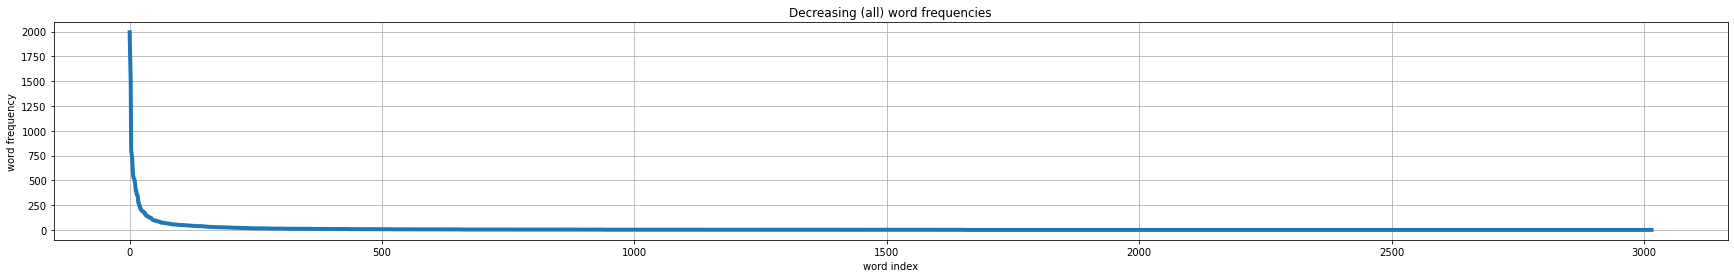

In [5]:
ax = df.freq.plot(figsize=(30,4), title='Decreasing (all) word frequencies', grid=True, lw=4);
ax.set_xlabel("word index");
ax.set_ylabel("word frequency");

<h3 style="color:black"> The Long Tail Problem </h3>

Notice that the distribution appears mostly flat and close to zero (mind the vertical scale) with the exception of a handful of words which have frequencies over 100. This long tail is problematic for Word2Vec and many NLP models because infrequent words are difficult to describe, define, and build vectors for. 

<span style="color:black"> Note that there are 3,000 unique word tokens (some are punctuations) in this text. Ordinarily, you could (or even should) investigate if there are both lowercase and uppercase version of words. If so, one approach would be to lowercase all words, and the long tail should shrink considerably from 3,000 words to a lower number. You could also drop words that are fewer than three characters.
    
If you do that, here are the remaining words:

In [6]:
LsWords2 = [w.lower() for w in LsWords if (len(w) > 3) and w.isalpha()]
print(LsWords2[:20])

['alice', 'adventures', 'wonderland', 'lewis', 'carroll', 'chapter', 'down', 'rabbit', 'hole', 'alice', 'beginning', 'very', 'tired', 'sitting', 'sister', 'bank', 'having', 'nothing', 'once', 'twice']


<span style="color:black">However, it is important to keep in mind that case change may alter the meaning of the word. For example, if we had a financial article with stock tickers, lowercasing words would collapse stock ticker "LOVE" and word "love" into the same word.


Now, if you recount words, some stopwords and punctuation are gone: 

In [7]:
LTDist2 = collections.Counter(LsWords2).most_common()
print(LTDist2[:20])

[('said', 462), ('alice', 398), ('that', 315), ('with', 180), ('they', 152), ('very', 144), ('what', 141), ('this', 134), ('little', 128), ('down', 102), ('there', 99), ('then', 94), ('about', 94), ('them', 88), ('know', 88), ('like', 85), ('were', 85), ('would', 83), ('went', 83), ('again', 83)]


Overall, the vocabulary has shrunk to 2,347. The count of "said" was 456 but now is 462, meaning that it probably started a few sentences in its title capitalization form. The count of "Alice" was 396 but now "alice" is 398, meaning that it appeared twice in other capitalizations.

<span style="color:black">Unfortunately, the long tail problem still remains. There are no other letter-case versions of "happy," so its count remains at one. You can take a closer look here: 

In [8]:
df2 = pd.DataFrame(LTDist2, columns=['word', 'freq'])
df2.set_index('word').T

word,said,alice,that,with,they,very,what,this,little,down,...,pictured,riper,years,loving,childhood,gather,sorrows,joys,remembering,happy
freq,462,398,315,180,152,144,141,134,128,102,...,1,1,1,1,1,1,1,1,1,1


<h3 style="color:black"> Filter Words With Low Counts </h3>

<span style="color:black">One common approach is to drop words with low counts, e.g., fewer than five. However, if you do this here, you would have fewer than 500 words left available. This highlights a key idea: If you wanted to train a Word2Vec model with a rich vocabulary, you would need a large corpus where words appear more than once. This book by itself would not be sufficient to provide more semantic meaning behind "happy," even though it is present in the book's vocabulary. 
    
<span style="color:black">Let's confirm the quantity of words remaining if only frequencies of six or more are considered. To filter out all words with low counts, create a mask array of Boolean values that is true when the count is $\ge 6$

In [9]:
HiFreqWords = (df2.freq >= 6)   # say, we only train vectors for words that appear 5+ times
HiFreqWords.values

array([ True,  True,  True, ..., False, False, False])

<span style="color:black">Use this masking array to place a red dotted line to separate words with frequencies $\ge6$ from the others.

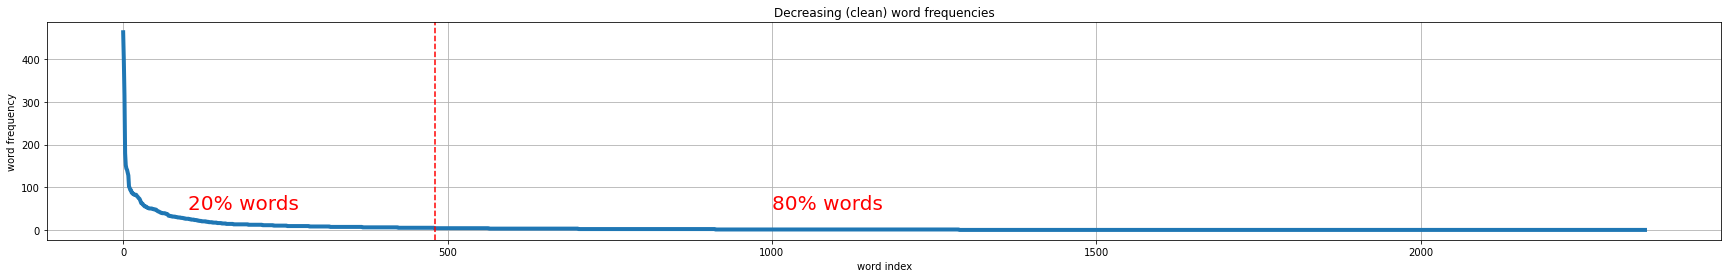

In [10]:
vPct = HiFreqWords.value_counts(normalize=True).values * 100
ax = df2.freq.plot(figsize=(30,4), title='Decreasing (clean) word frequencies', grid=True, lw=4);
ax.axvline(sum(HiFreqWords), color='r', linestyle='--')
ax.text(100, 50, f'{vPct[1]:.0f}% words', size=20, color='r')
ax.text(1000, 50, f'{vPct[0]:.0f}% words', size=20, color='r')
ax.set_xlabel("word index");
ax.set_ylabel("word frequency");

<span style="color:black">The plot shows that $\le500$ words appear at least six times in the book. This is about 20% of the vocabulary.

<span style="color:black">Some seemingly common and meaningful words are either rare in the book or do not appear at all. You can use synonyms to increase the count of either synonym. For example, "unhappy" appears twice, but "sad" does not appear at all. If we train Word2Vec to recognize "unhappy," then the same vector could be used for "sad." However, their meanings can diverge in some contexts. For example, "SAD" is also an acronym for "Seasonal Affective Disorder".

<span style="color:black">Additionally, you might use lemmatization to standardize words further. That means that Word2Vec vocabulary built on lemmatized words would only contain roots of the verbs. Then to retrieve a vector for the word "happier," you need to lemmatize it before searching for its vector.

In [11]:
df2.query('word=="happy" or word=="sad"')  # rare and OOV words
DsDist2 = collections.Counter(LsWords2)    # dictionary of words as keys and their counts as values
print([(w, DsDist2[w]) for w in df2.word if 'happ' in w])  # find words containing 'happ'

,word,freq
2346,happy,1


[('happen', 8), ('happened', 7), ('happens', 5), ('unhappy', 2), ('happening', 1), ('happy', 1)]


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

You will repeat the previous analysis on William Shakespeare's *Hamlet*, which is a slightly longer text. You would expect it to be more complex than the children's book. The complexity here is reflected in the number of unique words appearing in the text and the words' length. You expect that the former will have fewer shorter words and more unique words, so the problem of the long tail is even more dramatic.

As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

## Task 1

Use NLTK to load words from Gutenberg's "*shakespeare-hamlet.txt*" corpus (it's actually a single document) into the `LsWords3` variable. 

<b>Hint:</b> Try the <code>nltk.corpus.gutenberg.words()</code> to retreive <code>'shakespeare-hamlet.txt'</code>.


In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
LsWords3 = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')  # a list of word tokens
print(LsWords3[:20])
    </pre>
    </details> 
</font>
<hr>

## Task 2

How much larger is the *Hamlet* document compared to *Alice's Adventures in Wonderland* (AiW) in terms of raw word token counts?

<b>Hint:</b>  <code>len(LsWords)</code> gives you the number of all word tokens in a document.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
n, n3 = len(LsWords), len(LsWords3)
print(f'Words: {n3}/Hamlet, {n}/AiW; Difference: {n3-n} words, {(n3/n-1)*100:.2f}% ')
    </pre>
    </details> 
</font>
<hr>

## Task 3

Create a DataFrame `df3` of ordered counts of words. For reference, review the creation of `df` in the Review section above.

<b>Hint:</b> Use <code>collections.Counter()</code> as above.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
LTDist3 = collections.Counter(LsWords3).most_common()
df3 = pd.DataFrame(LTDist3, columns=['word', 'freq'])
df3.set_index('word').T            # set 'word' column values as indices, transpose and display
    </pre>
    </details> 
</font>
<hr>

## Task 4

Create a plot diagram of counts as with `df` above. How does the long tail from `df3` counts compare to that of `df`?

<b>Hint:</b> Use <code>df3.freq.plot()</code> as above for <code>df</code>.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
ax = df3.freq.plot(figsize=(30,4), title='Decreasing (all) word frequencies', grid=True, lw=4);
ax.set_xlabel("word index");
ax.set_ylabel("word frequency");
    </pre>
    </details> 
</font>

<hr>

## Task 5

What is the difference between unique word frequencies in *Hamlet* and *AiW*, in terms of counts and percent?

<b>Hint:</b> Use <code>len(df), len(df3)</code> to retrieve the number of rows and the count of unique word tokens, i.e., the vocabulary size of each document.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
n, n3 = len(df), len(df3)
print(f'Unique words: {n3}/Hamlet, {n}/AiW. Difference: {n3 - n} words {(n3/n-1)*100:.2f}%')
    </pre>
    </details> 
</font>
<hr>

## Task 6

Repeat the preprocessing you did in the review above on *Hamlet* to create a list `LsWords4` that has all lowercase words of four or more letters only. What is the decrease in vocabulary from the full text of *Hamlet*? Then, compute `df4` with the counts of these preprocessed words as with `df3`. Plot the results as you did in Task 4. How does the thresholded plot of `df4` compare to that of `df3`?

<b>Hint:</b> Repeat the steps for <code>df2</code>.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
LsWords4 = [w.lower() for w in LsWords3 if (len(w) > 3) and w.isalpha()]
df4 = pd.DataFrame(collections.Counter(LsWords4).most_common(), columns=['word', 'freq'])
df4.set_index('word').T

print(f'Decrease in vocabulary is {(len(df3)/len(df4) - 1)*100:.2f}%')
HiFreqWords = (df4.freq >= 6)   # say, we only train vectors for words that appear 5+ times
vPct = HiFreqWords.value_counts(normalize=True).values * 100
ax = df4.freq.plot(figsize=(30,4), title='Decreasing (clean) word frequencies', grid=True, lw=4);
ax.axvline(sum(HiFreqWords), color='r', linestyle='--')
ax.text(100, 50, f'{vPct[1]:.0f}% words', size=20, color='r')
ax.text(1000, 50, f'{vPct[0]:.0f}% words', size=20, color='r')
ax.set_xlabel("word index");
ax.set_ylabel("word frequency");
    </pre>
    </details> 
</font>
<hr>